In [3]:
# Import necessary libraries
import sys
import os
sys.path.append('../src')  # Add src directory to path

from data_loader import load_enphase_data, basic_data_info
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set up plotting
plt.style.use('default')
sns.set_palette("husl")

# Load the data
df = load_enphase_data()
basic_data_info(df)

Matplotlib is building the font cache; this may take a moment.


Dataset shape: (70272, 5)
Columns: ['Date/Time', 'Energy Produced (Wh)', 'Energy Consumed (Wh)', 'Exported to Grid (Wh)', 'Imported from Grid (Wh)']
Date range: 09/16/2023 00:00 to 09/16/2025 23:45

=== Dataset Overview ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70272 entries, 0 to 70271
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Date/Time                70272 non-null  object
 1   Energy Produced (Wh)     70272 non-null  int64 
 2   Energy Consumed (Wh)     70272 non-null  int64 
 3   Exported to Grid (Wh)    70272 non-null  int64 
 4   Imported from Grid (Wh)  70272 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 2.7+ MB
None

=== First few rows ===
          Date/Time  Energy Produced (Wh)  Energy Consumed (Wh)  \
0  09/16/2023 00:00                     0                   110   
1  09/16/2023 00:15                     0                    72   
2  09/16/2023 00:

/var/folders/c4/7rqcnh_x3_s594r5nysgtb280000gn/T/ipykernel_70297/1083865984.py:33: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_data = df_kwh.resample('M').mean()


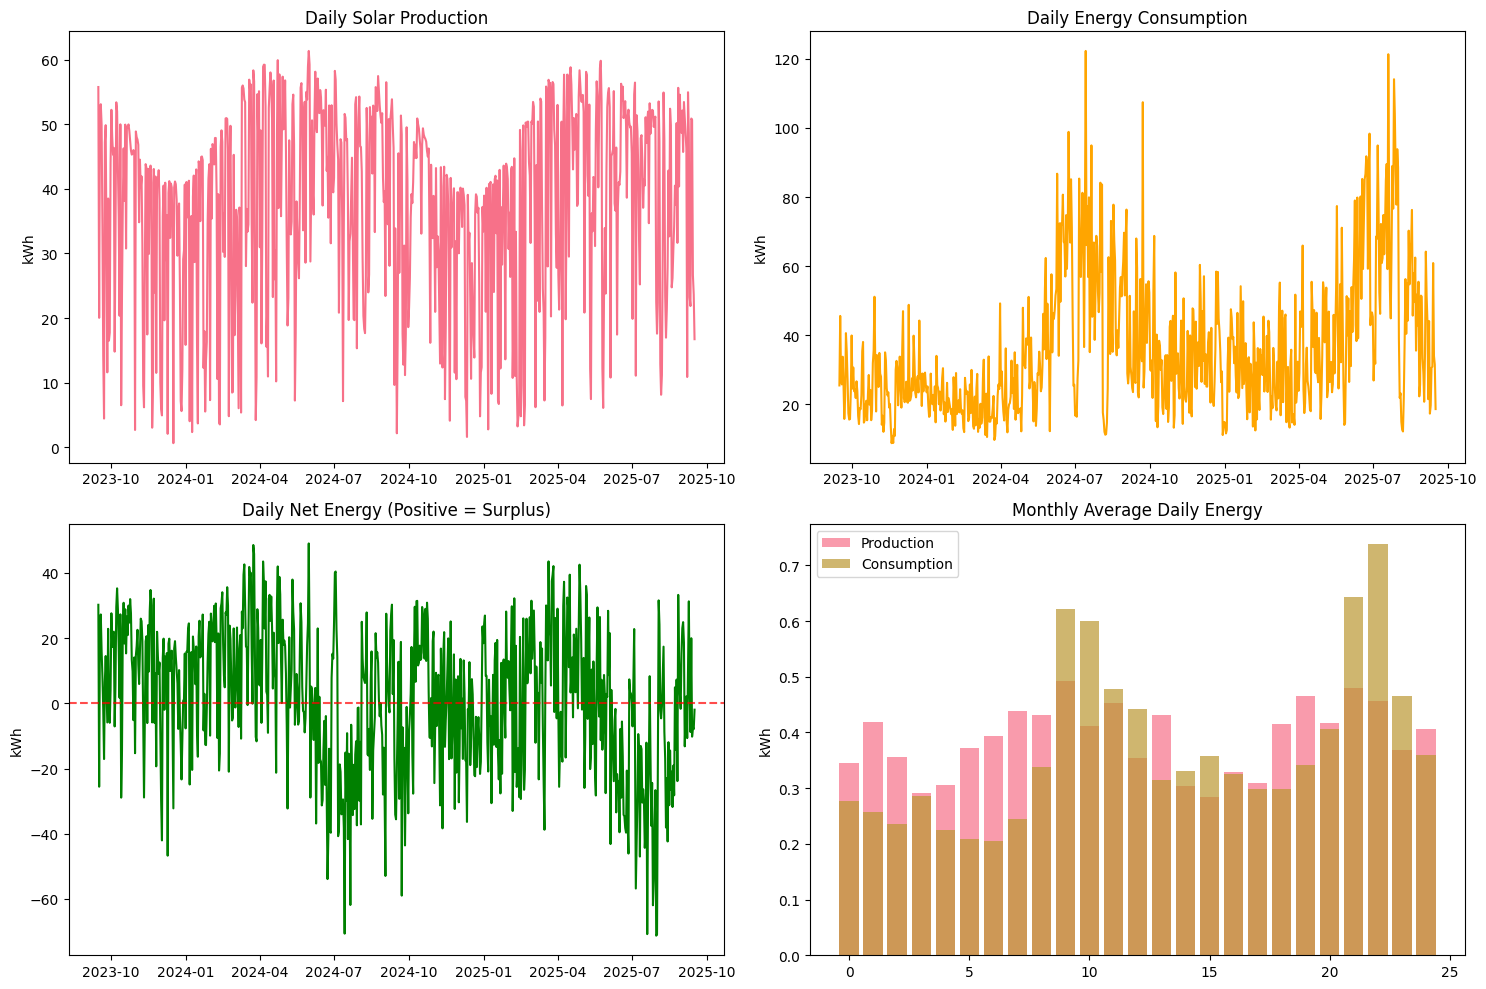

Average daily production: 37.4 kWh
Average daily consumption: 36.0 kWh
Days with energy surplus: 404 out of 732


In [4]:
# Convert Date/Time to datetime and set as index
df['Date/Time'] = pd.to_datetime(df['Date/Time'])
df.set_index('Date/Time', inplace=True)

# Convert Wh to kWh for easier reading
df_kwh = df / 1000
df_kwh.columns = ['Production (kWh)', 'Consumption (kWh)', 'Export (kWh)', 'Import (kWh)']

# Create daily summaries
daily_data = df_kwh.resample('D').sum()

# Plot daily production vs consumption
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Daily production over time
axes[0,0].plot(daily_data.index, daily_data['Production (kWh)'])
axes[0,0].set_title('Daily Solar Production')
axes[0,0].set_ylabel('kWh')

# Daily consumption over time
axes[0,1].plot(daily_data.index, daily_data['Consumption (kWh)'], color='orange')
axes[0,1].set_title('Daily Energy Consumption')
axes[0,1].set_ylabel('kWh')

# Net energy (production - consumption)
net_energy = daily_data['Production (kWh)'] - daily_data['Consumption (kWh)']
axes[1,0].plot(daily_data.index, net_energy, color='green')
axes[1,0].axhline(y=0, color='red', linestyle='--', alpha=0.7)
axes[1,0].set_title('Daily Net Energy (Positive = Surplus)')
axes[1,0].set_ylabel('kWh')

# Monthly averages
monthly_data = df_kwh.resample('M').mean()
axes[1,1].bar(range(len(monthly_data)), monthly_data['Production (kWh)'], alpha=0.7, label='Production')
axes[1,1].bar(range(len(monthly_data)), monthly_data['Consumption (kWh)'], alpha=0.7, label='Consumption')
axes[1,1].set_title('Monthly Average Daily Energy')
axes[1,1].set_ylabel('kWh')
axes[1,1].legend()

plt.tight_layout()
plt.show()

# Print some basic stats
print(f"Average daily production: {daily_data['Production (kWh)'].mean():.1f} kWh")
print(f"Average daily consumption: {daily_data['Consumption (kWh)'].mean():.1f} kWh")
print(f"Days with energy surplus: {(net_energy > 0).sum()} out of {len(net_energy)}")

/var/folders/c4/7rqcnh_x3_s594r5nysgtb280000gn/T/ipykernel_70297/1991454525.py:40: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_max = df_kwh.resample('M')['Production (kWh)'].max()


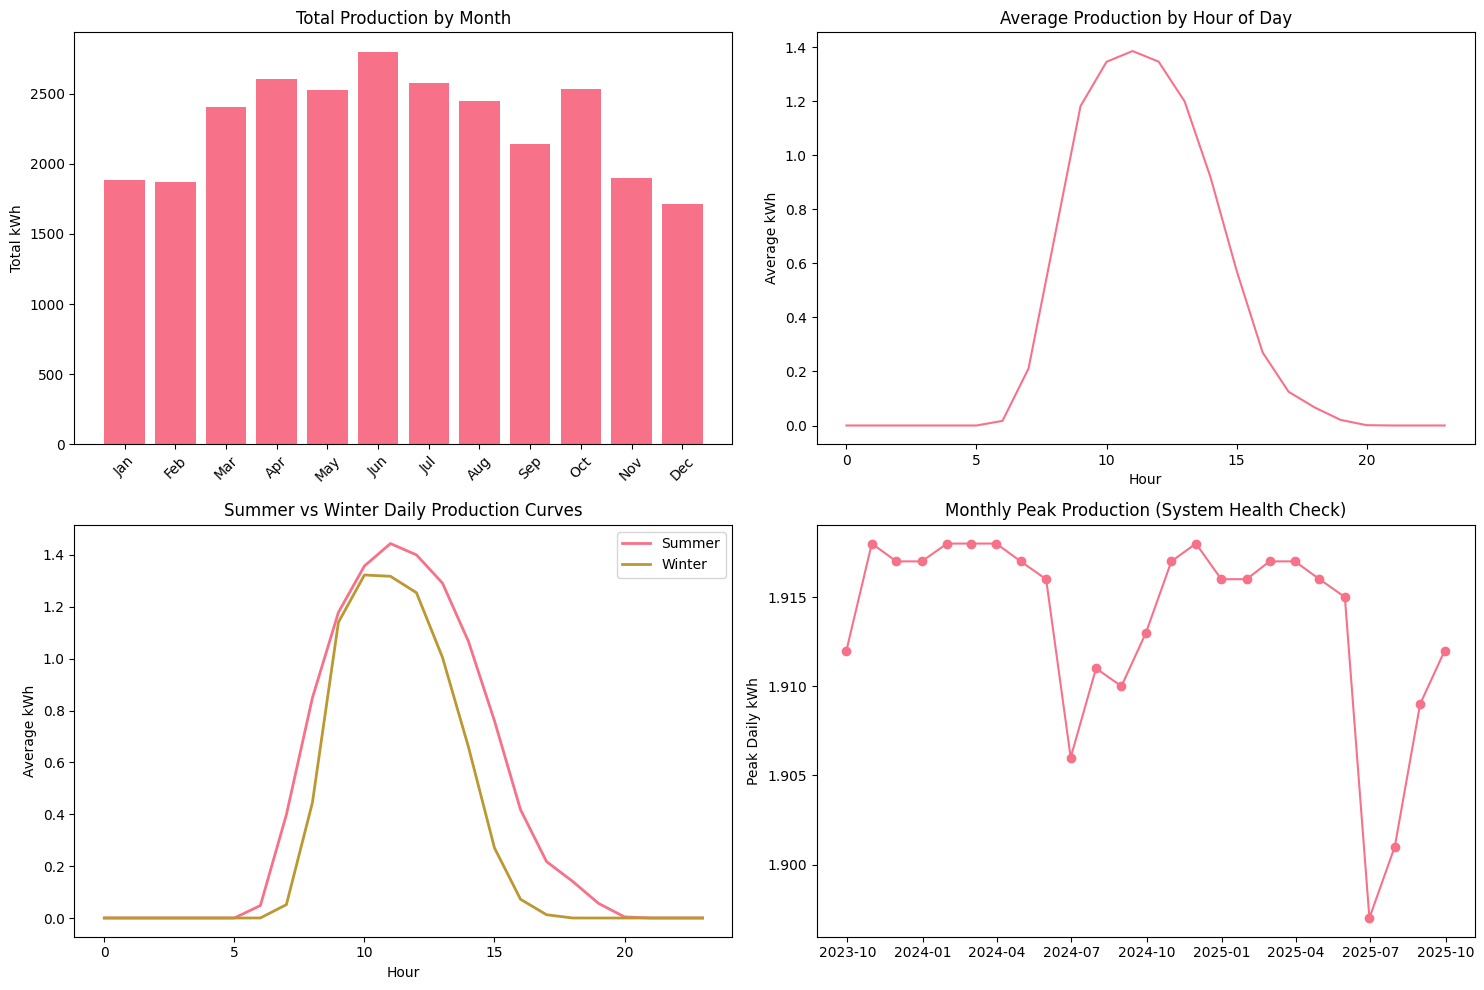

Highest production month: Jun (2798 kWh)
Lowest production month: Dec (1711 kWh)
Peak daily production hour: 11:00


In [5]:
# Create more detailed seasonal analysis
df_kwh['Month'] = df_kwh.index.month
df_kwh['Hour'] = df_kwh.index.hour

# Monthly production patterns
monthly_production = df_kwh.groupby('Month')['Production (kWh)'].sum()

# Plot monthly totals
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Monthly production bar chart
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
axes[0,0].bar(months, monthly_production.values)
axes[0,0].set_title('Total Production by Month')
axes[0,0].set_ylabel('Total kWh')
axes[0,0].tick_params(axis='x', rotation=45)

# Daily production pattern (average by hour)
hourly_avg = df_kwh.groupby('Hour')['Production (kWh)'].mean()
axes[0,1].plot(hourly_avg.index, hourly_avg.values)
axes[0,1].set_title('Average Production by Hour of Day')
axes[0,1].set_xlabel('Hour')
axes[0,1].set_ylabel('Average kWh')

# Seasonal comparison (summer vs winter months)
summer_months = [12, 1, 2] if monthly_production[1] > monthly_production[7] else [6, 7, 8]
winter_months = [6, 7, 8] if monthly_production[1] > monthly_production[7] else [12, 1, 2]

summer_data = df_kwh[df_kwh['Month'].isin(summer_months)].groupby('Hour')['Production (kWh)'].mean()
winter_data = df_kwh[df_kwh['Month'].isin(winter_months)].groupby('Hour')['Production (kWh)'].mean()

axes[1,0].plot(summer_data.index, summer_data.values, label='Summer', linewidth=2)
axes[1,0].plot(winter_data.index, winter_data.values, label='Winter', linewidth=2)
axes[1,0].set_title('Summer vs Winter Daily Production Curves')
axes[1,0].set_xlabel('Hour')
axes[1,0].set_ylabel('Average kWh')
axes[1,0].legend()

# Production efficiency over time (to check for degradation)
monthly_max = df_kwh.resample('M')['Production (kWh)'].max()
axes[1,1].plot(monthly_max.index, monthly_max.values, marker='o')
axes[1,1].set_title('Monthly Peak Production (System Health Check)')
axes[1,1].set_ylabel('Peak Daily kWh')

plt.tight_layout()
plt.show()

# Print key insights
print(f"Highest production month: {months[monthly_production.idxmax()-1]} ({monthly_production.max():.0f} kWh)")
print(f"Lowest production month: {months[monthly_production.idxmin()-1]} ({monthly_production.min():.0f} kWh)")
print(f"Peak daily production hour: {hourly_avg.idxmax()}:00")

In [6]:
# Fix the deprecation warnings by updating resample syntax
# Convert Date/Time to datetime and set as index (if not done already)
if 'Date/Time' in df.columns:
    df['Date/Time'] = pd.to_datetime(df['Date/Time'])
    df.set_index('Date/Time', inplace=True)

# Convert Wh to kWh for easier reading
df_kwh = df / 1000
df_kwh.columns = ['Production (kWh)', 'Consumption (kWh)', 'Export (kWh)', 'Import (kWh)']

# Create daily summaries using updated syntax
daily_data = df_kwh.resample('D').sum()  # 'D' is still fine
monthly_data = df_kwh.resample('ME').mean()  # Changed 'M' to 'ME'

# Updated monthly analysis
df_kwh['Month'] = df_kwh.index.month
df_kwh['Hour'] = df_kwh.index.hour

# Monthly production patterns
monthly_production = df_kwh.groupby('Month')['Production (kWh)'].sum()

# Production efficiency over time (fixed warning)
monthly_max = df_kwh.resample('ME')['Production (kWh)'].max()  # Changed 'M' to 'ME'

print("Fixed deprecation warnings!")
print(f"Data spans: {df_kwh.index.min()} to {df_kwh.index.max()}")
print(f"Monthly production range: {monthly_production.min():.0f} - {monthly_production.max():.0f} kWh")

Fixed deprecation warnings!
Data spans: 2023-09-16 00:00:00 to 2025-09-16 23:45:00
Monthly production range: 1711 - 2798 kWh


Model Performance:
Mean Absolute Error: 9.61 kWh
R² Score: 0.192
Average daily production: 41.98 kWh


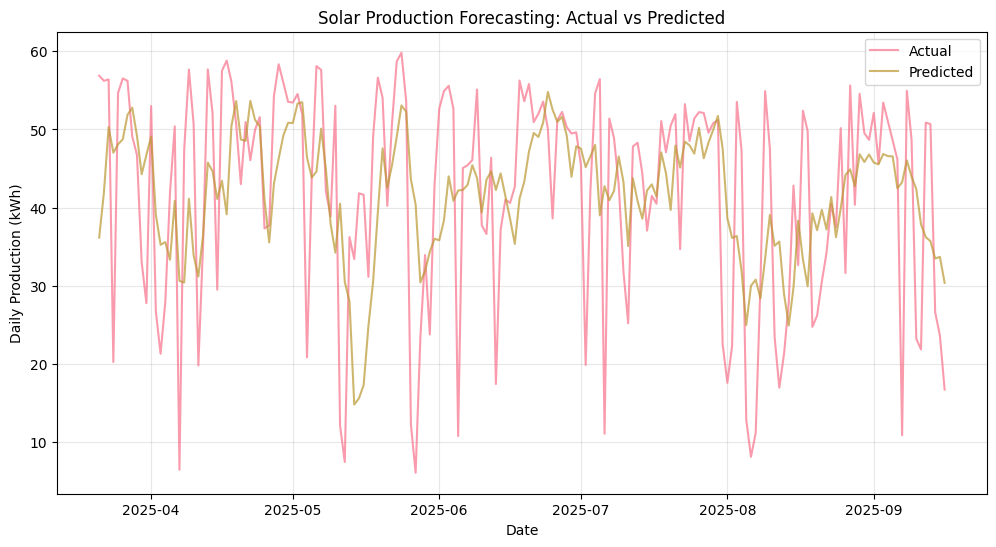


Feature Importance:
          feature  importance
4   prod_7day_avg    0.504944
5  prod_30day_avg    0.207480
1     day_of_year    0.166660
2     day_of_week    0.085329
0           month    0.025538
3         quarter    0.010049


In [8]:
# Prepare data for machine learning
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np

# Create daily dataset with features
daily_features = daily_data.copy()

# Add time-based features
daily_features['month'] = daily_features.index.month
daily_features['day_of_year'] = daily_features.index.dayofyear
daily_features['day_of_week'] = daily_features.index.dayofweek
daily_features['quarter'] = daily_features.index.quarter

# Add rolling averages (weather patterns)
daily_features['prod_7day_avg'] = daily_features['Production (kWh)'].rolling(7).mean()
daily_features['prod_30day_avg'] = daily_features['Production (kWh)'].rolling(30).mean()

# Drop rows with NaN (from rolling averages)
daily_features = daily_features.dropna()

# Prepare features (X) and target (y)
feature_columns = ['month', 'day_of_year', 'day_of_week', 'quarter', 'prod_7day_avg', 'prod_30day_avg']
X = daily_features[feature_columns]
y = daily_features['Production (kWh)']

# Split data (use last 6 months as test set)
split_date = daily_features.index[-180]  # Last 6 months
X_train = X[X.index < split_date]
X_test = X[X.index >= split_date]
y_train = y[y.index < split_date]
y_test = y[y.index >= split_date]

# Train Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate model
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Model Performance:")
print(f"Mean Absolute Error: {mae:.2f} kWh")
print(f"R² Score: {r2:.3f}")  # Fixed the missing quote here
print(f"Average daily production: {y_test.mean():.2f} kWh")

# Plot actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test.values, label='Actual', alpha=0.7)
plt.plot(y_test.index, y_pred, label='Predicted', alpha=0.7)
plt.title('Solar Production Forecasting: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Daily Production (kWh)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Feature importance
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

Enhanced Model Performance:
Mean Absolute Error: 1.61 kWh (vs 9.61 before)
R² Score: 0.977 (vs 0.192 before)


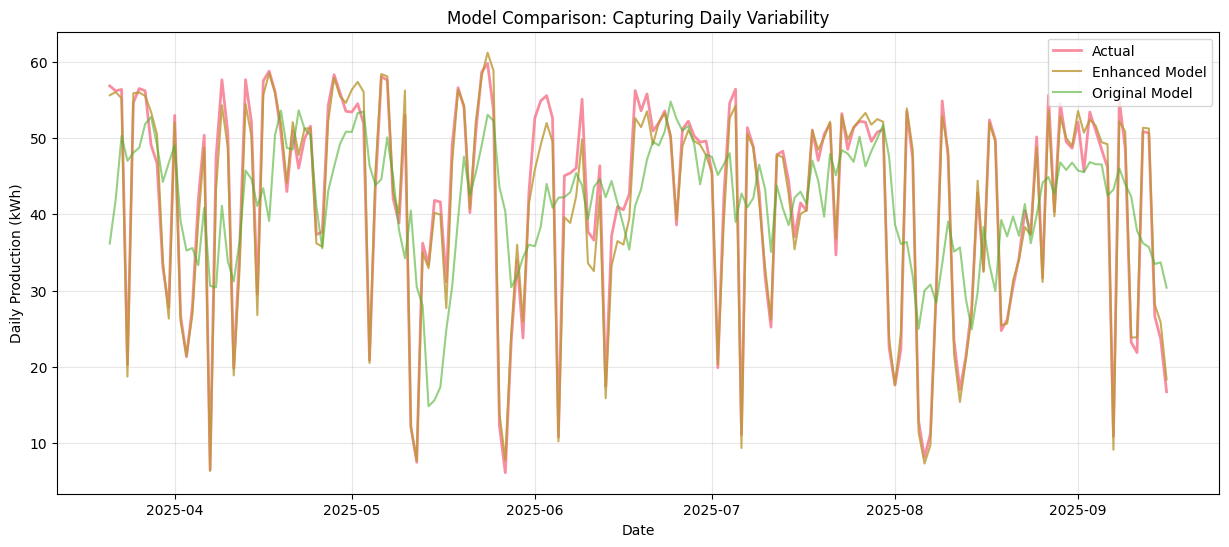


Enhanced Model Feature Importance:
                  feature  importance
13         seasonal_ratio    0.885456
9           prod_7day_max    0.090549
1             day_of_year    0.007657
10          prod_7day_min    0.004699
0                   month    0.004128
8           prod_7day_avg    0.001956
12          cons_7day_avg    0.001670
11  consumption_yesterday    0.000974
7           prod_3day_std    0.000952
6           prod_week_ago    0.000898


In [9]:
# Enhanced model with more features to capture daily variability
# Add more granular features
daily_features_v2 = daily_data.copy()

# Time-based features
daily_features_v2['month'] = daily_features_v2.index.month
daily_features_v2['day_of_year'] = daily_features_v2.index.dayofyear
daily_features_v2['day_of_week'] = daily_features_v2.index.dayofweek
daily_features_v2['quarter'] = daily_features_v2.index.quarter

# Weather proxy features (using production patterns)
daily_features_v2['prod_yesterday'] = daily_features_v2['Production (kWh)'].shift(1)
daily_features_v2['prod_2days_ago'] = daily_features_v2['Production (kWh)'].shift(2)
daily_features_v2['prod_week_ago'] = daily_features_v2['Production (kWh)'].shift(7)

# Variability measures
daily_features_v2['prod_3day_std'] = daily_features_v2['Production (kWh)'].rolling(3).std()
daily_features_v2['prod_7day_avg'] = daily_features_v2['Production (kWh)'].rolling(7).mean()
daily_features_v2['prod_7day_max'] = daily_features_v2['Production (kWh)'].rolling(7).max()
daily_features_v2['prod_7day_min'] = daily_features_v2['Production (kWh)'].rolling(7).min()

# Consumption patterns (might correlate with weather/season)
daily_features_v2['consumption_yesterday'] = daily_features_v2['Consumption (kWh)'].shift(1)
daily_features_v2['cons_7day_avg'] = daily_features_v2['Consumption (kWh)'].rolling(7).mean()

# Performance ratio (actual vs expected seasonal)
seasonal_avg = daily_features_v2.groupby('month')['Production (kWh)'].transform('mean')
daily_features_v2['seasonal_ratio'] = daily_features_v2['Production (kWh)'] / seasonal_avg

# Drop NaN rows
daily_features_v2 = daily_features_v2.dropna()

# New feature set
feature_columns_v2 = [
    'month', 'day_of_year', 'day_of_week', 'quarter',
    'prod_yesterday', 'prod_2days_ago', 'prod_week_ago',
    'prod_3day_std', 'prod_7day_avg', 'prod_7day_max', 'prod_7day_min',
    'consumption_yesterday', 'cons_7day_avg', 'seasonal_ratio'
]

X_v2 = daily_features_v2[feature_columns_v2]
y_v2 = daily_features_v2['Production (kWh)']

# Same train/test split
split_date = daily_features_v2.index[-180]
X_train_v2 = X_v2[X_v2.index < split_date]
X_test_v2 = X_v2[X_v2.index >= split_date]
y_train_v2 = y_v2[y_v2.index < split_date]
y_test_v2 = y_v2[y_v2.index >= split_date]

# Try a different model - Gradient Boosting often handles variability better
from sklearn.ensemble import GradientBoostingRegressor

gb_model = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, random_state=42)
gb_model.fit(X_train_v2, y_train_v2)

y_pred_v2 = gb_model.predict(X_test_v2)

# Compare models
mae_v2 = mean_absolute_error(y_test_v2, y_pred_v2)
r2_v2 = r2_score(y_test_v2, y_pred_v2)

print(f"Enhanced Model Performance:")
print(f"Mean Absolute Error: {mae_v2:.2f} kWh (vs {mae:.2f} before)")
print(f"R² Score: {r2_v2:.3f} (vs {r2:.3f} before)")

# Plot comparison
plt.figure(figsize=(15, 6))
plt.plot(y_test_v2.index, y_test_v2.values, label='Actual', alpha=0.8, linewidth=2)
plt.plot(y_test_v2.index, y_pred_v2, label='Enhanced Model', alpha=0.8)
plt.plot(y_test.index, y_pred, label='Original Model', alpha=0.6)
plt.title('Model Comparison: Capturing Daily Variability')
plt.xlabel('Date')
plt.ylabel('Daily Production (kWh)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Feature importance for new model
feature_importance_v2 = pd.DataFrame({
    'feature': feature_columns_v2,
    'importance': gb_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nEnhanced Model Feature Importance:")
print(feature_importance_v2.head(10))

Found 73 potentially problematic days:
            Production (kWh)  seasonal_ratio
Date/Time                                   
2023-09-23             4.440        0.126353
2023-10-14             6.504        0.159332
2023-10-31             2.675        0.065531
2023-11-01            48.875        1.541993
2023-11-02            47.972        1.513503


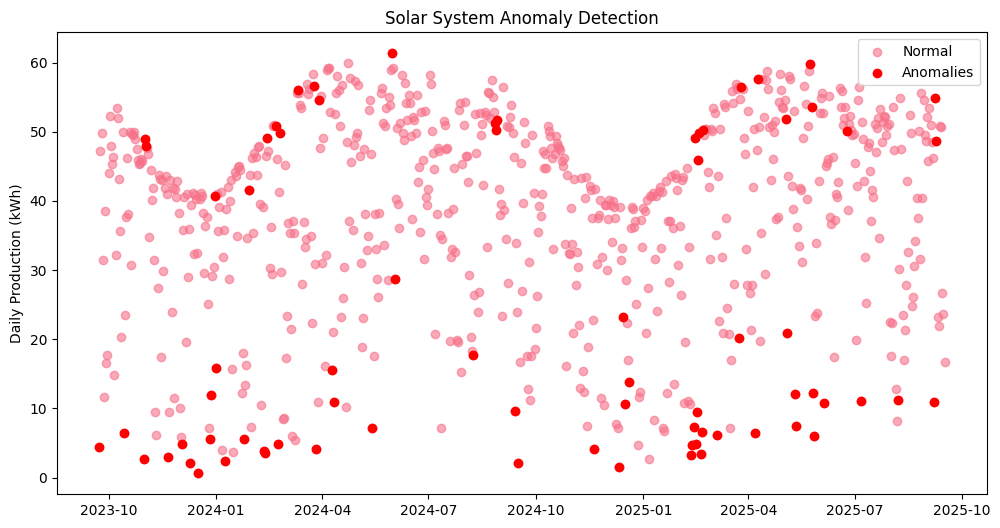

In [10]:
# Detect days when your system underperformed
from sklearn.ensemble import IsolationForest

# Create anomaly detector
iso_forest = IsolationForest(contamination=0.1, random_state=42)
daily_features_v2['anomaly_score'] = iso_forest.fit_predict(X_v2[['prod_7day_avg', 'seasonal_ratio', 'prod_3day_std']])

# Find anomalous days
anomalies = daily_features_v2[daily_features_v2['anomaly_score'] == -1]
print(f"Found {len(anomalies)} potentially problematic days:")
print(anomalies[['Production (kWh)', 'seasonal_ratio']].head())

# Plot anomalies
plt.figure(figsize=(12, 6))
plt.scatter(daily_features_v2.index, daily_features_v2['Production (kWh)'], alpha=0.6, label='Normal')
plt.scatter(anomalies.index, anomalies['Production (kWh)'], color='red', label='Anomalies')
plt.title('Solar System Anomaly Detection')
plt.ylabel('Daily Production (kWh)')
plt.legend()
plt.show()

In [ ]:
# Location-based energy optimization analysis
import sys
sys.path.append('../src')
from core.location_loader import create_notebook_location, get_location_electricity_rates
import os

# Get location and electricity rates
location = create_notebook_location()
nrel_api_key = os.environ.get('NREL_API_KEY')
electricity_rates = get_location_electricity_rates(location, nrel_api_key)

# Extract rates (convert from cents/kWh to $/kWh)
import_rate = electricity_rates['annual_cost_per_kwh']  # $/kWh bought from grid
export_rate = electricity_rates['feed_in_rate_per_kwh']  # $/kWh sold back to grid

print(f"🔌 Location-Based Rates for {location.location_name}:")
print(f"  Import rate (buying): ${import_rate:.4f}/kWh ({electricity_rates['residential_rate']:.2f}¢/kWh)")
print(f"  Export rate (selling): ${export_rate:.4f}/kWh ({electricity_rates['feed_in_tariff']:.2f}¢/kWh)")
print(f"  Rate source: {electricity_rates['source']}")

# Calculate financial impact using location-specific rates
daily_features_v2['export_income'] = daily_features_v2['Export (kWh)'] * export_rate
daily_features_v2['import_cost'] = daily_features_v2['Import (kWh)'] * import_rate
daily_features_v2['daily_net_cost'] = daily_features_v2['import_cost'] - daily_features_v2['export_income']

# Self-consumption saves money at the full retail rate
self_consumed = daily_features_v2['Production (kWh)'] - daily_features_v2['Export (kWh)']
daily_features_v2['self_consumption_savings'] = self_consumed * import_rate

# Total daily solar benefit
daily_features_v2['total_daily_benefit'] = daily_features_v2['export_income'] + daily_features_v2['self_consumption_savings']

total_benefit = daily_features_v2['total_daily_benefit'].sum()
total_net_cost = daily_features_v2['daily_net_cost'].sum()

print(f"\n💰 Financial Analysis for {len(daily_features_v2)} days:")
print(f"  Total solar benefit: ${total_benefit:.2f}")
print(f"  Net electricity cost: ${total_net_cost:.2f}")
print(f"  Average daily benefit: ${total_benefit / len(daily_features_v2):.2f}")
print(f"  Average monthly benefit: ${total_benefit / len(daily_features_v2) * 30:.2f}")

# Estimate annual savings
annual_benefit = total_benefit * (365 / len(daily_features_v2))
print(f"  Projected annual benefit: ${annual_benefit:.0f}")

# Self-consumption optimization
daily_features_v2['self_consumption_rate'] = (
    (daily_features_v2['Consumption (kWh)'] - daily_features_v2['Import (kWh)']) / 
    daily_features_v2['Production (kWh)']
).fillna(0)

avg_self_consumption = daily_features_v2['self_consumption_rate'].mean()
print(f"\n📊 Self-Consumption Analysis:")
print(f"  Average self-consumption rate: {avg_self_consumption:.1%}")
print(f"  Self-consumption value: ${daily_features_v2['self_consumption_savings'].sum():.2f}")
print(f"  Export income: ${daily_features_v2['export_income'].sum():.2f}")

# Rate impact analysis
if electricity_rates['national_comparison']['is_above_average']:
    rate_impact = "Higher local rates increase solar value"
else:
    rate_impact = "Lower local rates reduce solar value compared to national average"
print(f"\n💡 Rate Impact: {rate_impact}")